In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../../lib')
from local_paths import analysis_dir

# Parameters

In [2]:
#============================================================================
# analysis type and result path
#============================================================================
# - stim onset-aligned
# analysis_name = 'stim_on'
# results_subdir = 'fix0_self_consistency_boot200-t2hh'

# - OR, fixation onset-aligned
analysis_name = 'fix_on'
results_subdir ='self_consistency_boot200-cp'

output_sfx = ''

#============================================================================
# selection criteria
#============================================================================
boots_spread = 25
min_clearance = 100
min_boots_frac = 0.5

# lower-clip stim-on latency at 0?  only relevant if analysis_name == stim_on
clamp_stim_on = True

In [3]:
# Parameters
analysis_name = "stim_on"
results_subdir = "fix0_self_consistency_boot200-t2hh"


# Preamble

In [4]:
results_dir = Path(analysis_dir+results_subdir).expanduser()
assert results_dir.is_dir()

if analysis_name == 'fix_on':
    res_tag = results_dir.stem.replace('self_consistency_boot200-cp', '')
else:
    res_tag = results_dir.stem.replace('fix0_self_consistency_boot200-t2hh', '')
if res_tag:
    res_tag = '-' + res_tag
print('results name tag:', res_tag)

clamp_stim_on = clamp_stim_on and (analysis_name == 'stim_on')

cols_to_save = ['Latency', 'Boots. stdev.', 'Clearance', 'T step', 'Boots. frac.']
if analysis_name == 'fix_on':
    cols_to_save += ['Peak 0 SC', 'Peak 0 time', 'Peak 1 SC', 'Peak 1 time']
else:
    cols_to_save += ['Peak SC', 'Peak time']

results name tag: 


# Load data

In [5]:
df = []
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            if analysis_name == 'fix_on':
                assert f['progress_report/crossing_point/all_done'][()]
            else:
                assert f['progress_report/time_to_half_height/all_done'][()]
        except (KeyError, AssertionError):
            continue

    if analysis_name == 'fix_on':
        df_ = pd.read_hdf(fp, 'crossing_point/latency_dataframe')
    else:
        try:
            df_ = pd.read_hdf(fp, 'time_to_half_height/return_fixation/latency_dataframe')
        except KeyError:
            continue

    df.append(df_)

df = pd.concat(df).set_index(['Session', 'Level', 'Name'])
assert not df.index.has_duplicates
print(df.shape)

(61808, 22)


# Select from all results

In [6]:
def select_latetency(
        lat_df, analysis_name=analysis_name,
        min_boots_frac=min_boots_frac, boots_spread=boots_spread,
        min_clearance=min_clearance,
        clamp_stim_on=clamp_stim_on):

    df = lat_df.copy()
    criteria = {}
    criteria['Is valid'] = np.isfinite(lat_df['Latency'].values)

    criteria['Clearance'] = lat_df['Clearance'].values >= min_clearance
    if analysis_name == 'fix_on':
        criteria['Peak time'] = (
            (lat_df['Latency'].values >= lat_df['Peak 0 time'].values)
            & (lat_df['Latency'].values <= lat_df['Peak 1 time'].values))
    else:
        criteria['Peak time'] = lat_df['Latency'].values <= lat_df['Peak time'].values

    if clamp_stim_on:
        criteria['Is positive'] = lat_df['Latency'].values > 0

    criteria['Boots. frac.'] = lat_df['Boots. frac., train'].values >= min_boots_frac
    criteria['Boots. spread'] = (
        (np.abs(lat_df['Boots. bias, train'].values) < boots_spread)
        & (lat_df['Boots. stdev., train'].values < boots_spread))
    criteria['Boots. clearance'] = lat_df['Boots. mean clearance, train'].values >= min_clearance

    for k, m in criteria.items():
        print(f'criterion: {k:<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')
    m = np.all(list(criteria.values()), axis=0)
    print(f'criterion: {"All":<20} passed: {m.mean()*100:.1f}% ({m.sum()} of {m.size})')

    return m

In [7]:
lat_df = df.copy()
lat_df['Selected'] = select_latetency(lat_df)

criterion: Is valid             passed: 92.1% (56896 of 61808)
criterion: Clearance            passed: 42.7% (26396 of 61808)
criterion: Peak time            passed: 76.0% (46988 of 61808)
criterion: Is positive          passed: 60.1% (37152 of 61808)
criterion: Boots. frac.         passed: 89.7% (55464 of 61808)
criterion: Boots. spread        passed: 11.5% (7096 of 61808)
criterion: Boots. clearance     passed: 58.9% (36397 of 61808)
criterion: All                  passed: 5.7% (3541 of 61808)


In [8]:
lat_df.loc[lat_df['Selected'], cols_to_save].to_csv(
    f'summary/{analysis_name}_latency{res_tag}{output_sfx}.csv.gz')

# Summarize array-level results

In [9]:
arreg = pd.read_csv('../../db/bank_array_regions.csv').astype({'Array ID': str})
arreg['Subject'] = [v[:2] for v in arreg['Session']]
arreg = arreg.groupby(['Subject', 'Array ID']).first()

In [10]:
lat_df = df.reset_index()
lat_df = lat_df[lat_df['Level']=='Array'].copy()
lat_df['Selected'] = select_latetency(lat_df)

criterion: Is valid             passed: 99.9% (880 of 881)
criterion: Clearance            passed: 57.9% (510 of 881)
criterion: Peak time            passed: 88.3% (778 of 881)
criterion: Is positive          passed: 73.7% (649 of 881)
criterion: Boots. frac.         passed: 97.4% (858 of 881)
criterion: Boots. spread        passed: 30.3% (267 of 881)
criterion: Boots. clearance     passed: 64.2% (566 of 881)
criterion: All                  passed: 22.4% (197 of 881)


In [11]:
adf = lat_df[lat_df['Selected']].copy()
adf['Subject'] = [v[:2] for v in adf['Session']]
adf['Region'] = arreg.loc[list(map(tuple, adf[['Subject', 'Name']].values))]['Region'].values

Array-level latencies, per session


<Axes: xlabel='Latency', ylabel='Density'>

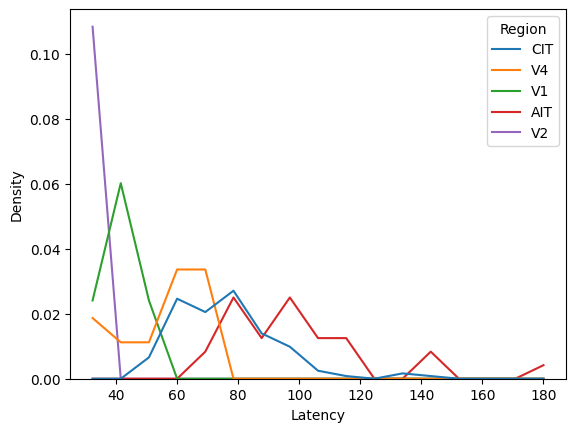

In [12]:
print('Array-level latencies, per session')
sns.histplot(data=adf, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False)

Array-level latencies, per session
After selecting for test boots frac


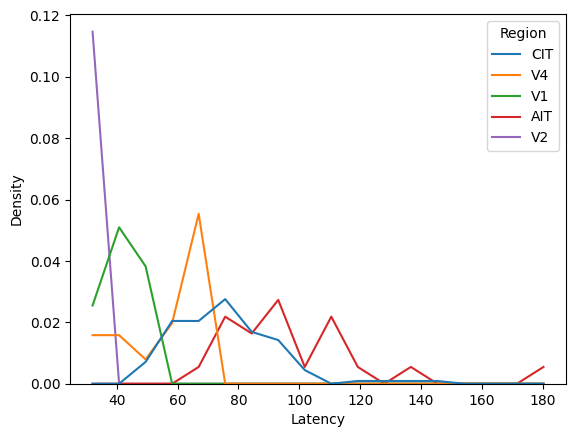

In [13]:
print('Array-level latencies, per session')
print('After selecting for test boots frac')
# note here and below, we select based on test boots frac because
# 1) array-level results are never reported but used as default parameters
# 2) as default parameters, the values should be reliable
adf = adf[adf['Boots. stdev.'] < boots_spread]  # select once
sns.histplot(data=adf, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False);

Array-level latencies, median across sessions


Latency Region  Selected  Boots. stdev.
Subject Name                                            
An      1      40.777027     V1       1.0       2.829201
Bf      7      49.024391     V4       1.0      11.962906
Bo      3      85.643951    AIT       1.0       7.618403
Fr      0      84.836067    CIT       1.0       5.733567
        1      57.280407    CIT       1.0       7.333486
        3      45.174843     V4       1.0       4.717983
Lo      0      75.704193    CIT       1.0       7.568948
        1      69.623894    CIT       1.0       4.245683
        2     105.937500    CIT       1.0       4.825991
Na      0      35.609756     V2       1.0       1.854954
        1      63.704433     V4       1.0       2.251224
        2      96.000000    AIT       1.0       4.788545
Oc      6      76.998276    AIT       1.0       4.187175
Pa      1      77.222221    CIT       1.0       3.490224
        2      60.719696    CIT       1.0       5.495264
Re      6     107.701866    AIT       1.0       7.037843
Ve      2     184.625000    AIT       1.0       4.328618
        3     117.094109    AIT       1.0      15.360119
Ye      0      76.725349    CIT       1.0       8.482317
        1      80.156250    CIT       1.0       4.622618

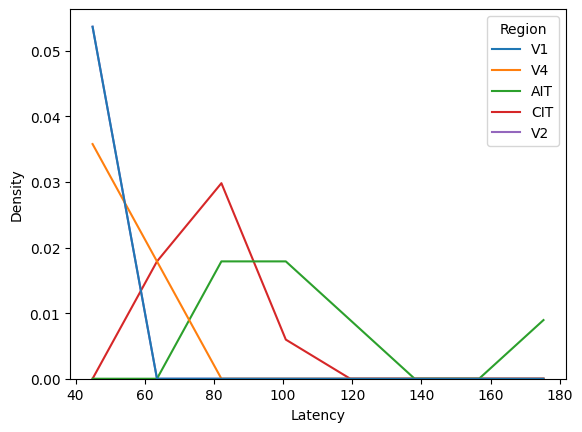

In [14]:
print('Array-level latencies, median across sessions')
df_ = adf.groupby(['Subject', 'Name']).agg({
    'Latency': 'median', 'Region': 'first', 'Selected': 'mean', 'Boots. stdev.': 'median'})
assert df_['Selected'].all()  # sanity check
df_ = df_[df_['Boots. stdev.'] < boots_spread]
sns.histplot(data=df_, x='Latency', hue='Region', stat='density', element='poly', common_norm=False, fill=False);
df_

In [15]:
print('Array-level latencies, median across arrays')
df_.groupby('Region').median()

Array-level latencies, median across arrays


,Latency,Selected,Boots. stdev.
Region,,,
AIT,101.850937,1.0,5.913194
CIT,76.725349,1.0,5.495264
V1,40.777027,1.0,2.829201
V2,35.609756,1.0,1.854954
V4,49.024391,1.0,4.717983


In [16]:
# save array-level resuilts median across sessions
gb = adf.groupby(['Subject', 'Name'])
df_ = gb[cols_to_save].median()
df_['Count'] = gb['Latency'].count()
df_['Region'] = gb['Region'].first()
df_['Level'] = 'Array'
df_ = df_[df_['Boots. stdev.'] < boots_spread]  # select twice
df_ = df_.reset_index().set_index(['Subject', 'Level', 'Name'])
df_.to_csv(f'summary/{analysis_name}_latency{res_tag}{output_sfx}-array_level.csv.gz')
df_

Latency  Boots. stdev.   Clearance  T step   
Subject Level Name                                                  
An      Array 1      40.777027       2.829201  171.941116    10.0  \
Bf      Array 7      49.024391      11.962906  249.024384    10.0   
Bo      Array 3      85.643951       7.618403  269.534485    10.0   
Fr      Array 0      84.836067       5.733567  272.242981    10.0   
              1      57.280407       7.333486  257.819763    10.0   
              3      45.174843       4.717983  211.568298    10.0   
Lo      Array 0      75.704193       7.568948  259.562958    10.0   
              1      69.623894       4.245683  251.385254    10.0   
              2     105.937500       4.825991  124.321938    10.0   
Na      Array 0      35.609756       1.854954  235.609756    10.0   
              1      63.704433       2.251224  224.259583    10.0   
              2      96.000000       4.788545  116.127663    10.0   
Oc      Array 6      76.998276       4.187175  220.447235    10.0   
Pa      Array 1      77.222221       3.490224  272.585236    10.0   
              2      60.719696       5.495264  248.985504    10.0   
Re      Array 6     107.701866       7.037843  259.013611    10.0   
Ve      Array 2     184.625000       4.328618  185.375000    10.0   
              3     117.094109      15.360119  252.905884    10.0   
Ye      Array 0      76.725349       8.482317  236.993240    10.0   
              1      80.156250       4.622618  271.488098    10.0   

                    Boots. frac.   Peak SC  Peak time  Count Region  
Subject Level Name                                                   
An      Array 1              1.0  0.561523       80.0      9     V1  
Bf      Array 7              1.0  0.105469       70.0      1     V4  
Bo      Array 3              1.0  0.785156      145.0     10    AIT  
Fr      Array 0              1.0  0.611328      170.0      9    CIT  
              1              1.0  0.643555      100.0      3    CIT  
              3              1.0  0.636230      110.0     12     V4  
Lo      Array 0              1.0  0.634766      115.0     10    CIT  
              1              1.0  0.693848      130.0      6    CIT  
              2              1.0  0.551758      180.0      3    CIT  
Na      Array 0              1.0  0.580078       70.0      1     V2  
              1              1.0  0.606934      100.0     16     V4  
              2              1.0  0.388672      170.0      1    AIT  
Oc      Array 6              1.0  0.596191      110.0      2    AIT  
Pa      Array 1              1.0  0.623047      140.0     35    CIT  
              2              1.0  0.608398      130.0     35    CIT  
Re      Array 6              1.0  0.784180      200.0      5    AIT  
Ve      Array 2              1.0  0.252930      270.0      1    AIT  
              3              1.0  0.441406      185.0      2    AIT  
Ye      Array 0              1.0  0.428711      150.0     21    CIT  
              1              1.0  0.502930      160.0      7    CIT